## Preface



First, if you don&rsquo;t already have the latest version of the `cfe` package
installed, grab it, along with some dependencies:



In [1]:
!pip install CFEDemands --upgrade --pre
!pip install xarray --upgrade
!pip install h5netcdf

Requirement already up-to-date: CFEDemands in /srv/app/venv/lib/python3.6/site-packages
You are using pip version 9.0.3, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Requirement already up-to-date: xarray in /srv/app/venv/lib/python3.6/site-packages
Requirement already up-to-date: setuptools>=41.2 in /srv/app/venv/lib/python3.6/site-packages (from xarray)
Requirement already up-to-date: numpy>=1.15 in /srv/app/venv/lib/python3.6/site-packages (from xarray)
Requirement already up-to-date: pandas>=0.25 in /srv/app/venv/lib/python3.6/site-packages (from xarray)
Requirement already up-to-date: pytz>=2017.2 in /srv/app/venv/lib/python3.6/site-packages (from pandas>=0.25->xarray)
Requirement already up-to-date: python-dateutil>=2.6.1 in /srv/app/venv/lib/python3.6/site-packages (from pandas>=0.25->xarray)
Requirement already up-to-date: six>=1.5 in /srv/app/venv/lib/python3.6/site-packages (from python-dateutil>=2.6.1->pandas

Second, load relevant dataset:



In [4]:
import cfe

# Results can be made persistent by saving them, and then re-loading...
r = cfe.from_dataset('./Nigeria_small.ds')

r['alpha'] = r.alpha.loc[r.alpha>0]  # Insist on alpha positive

## Choosing reference prices, budget, and units



We&rsquo;ll want to choose reference prices (a choice of `t` and `m`) and
units (`u`).  You can examine possibilities by looking at:



In [5]:
r.prices.coords

Coordinates:
  * i        (i) object '(Cocoyam, Spinach, etc)' ... 'Yam-roots'
  * t        (t) int64 2010 2012 2015 2018
  * m        (m) int64 1
  * u        (u) object '1. KILOGRAMS (KG)' '2. GRAMS (G)' ... 'litre (l)'

Below we choose first market in first period, but this is a matter of
choice.  We also choose prices for goods measured in &rsquo;Kilograms&rsquo;; this
may vary with the dataset.  To inspect possible units look at:



In [12]:
t = r.firstround  # First round
m = r.coords['m'][0] # First market

# Get median budget
x = r.get_predicted_expenditures().sum('i')
medianx = x.where(x>0).sel(t=t,m=m).median('j').values

# Note selection of prices for first market in first period for /kgs/.
# For goods never measured in kgs prices will be missing. 
p = r.prices.sel(t=t,m=m,u='Kilograms',drop=True).to_dataframe().squeeze().dropna()
p

i
(Cocoyam, Spinach, etc)     68.315621
Agricultural eggs          202.653897
Avocado pear                72.225457
Baby milk powder           231.375755
Bananas                     90.821855
                              ...    
Wheat flour                 98.954978
White beans                101.311511
Wild game meat             426.200899
Yam flour                  225.491453
Yam-roots                   61.296256
Name: prices, Length: 90, dtype: float64

And with $(x,p)$ defined we can calculate example demands:



In [13]:
# Expenditures divided by reference prices per Kilogram
c=(r.demands(medianx)/p).dropna()
c

i
(Cocoyam, Spinach, etc)                   0.366933
Agricultural eggs                         2.789957
Bananas                                   0.788088
Beef                                      0.186890
Beer (local and imported)                 2.426062
Bread                                     0.660163
Brown beans                               0.508576
Chicken                                   0.104248
Chocolate drinks                          1.989477
Cocoyam                                   0.367896
Condiments,(salt,spices,pepper, etc)     43.886105
Fish-Dried                                0.959619
Fish-Fresh                                0.844145
Fish-Frozen                               0.076023
Fish-Smoked                             153.587912
Garden eggs/egg plant                     0.323181
Gari -Yellow                              0.413920
Gari-White                                1.151248
Goat                                      0.147698
Groundnut oil                

## Mapping to Nutrients



We&rsquo;ve seen how to map prices and budgets into vectors of consumption
quantities using `cfe.Result.demands`.  Next we want to think about
how to map these into bundles of *nutrients*.  The information needed
for the mapping comes from a &ldquo;Food Conversion Table&rdquo; (or database,
such as the [USDA Food Central Database](https://fdc.nal.usda.gov/)).   Here we&rsquo;ve adapted (with
thanks to Alessandro Tarozzi of the Universitat Pompeu Fabra) a food
conversion table developed by Gopalan et al (1980) to the foods
reported in the Indian ICRISAT data:



In [14]:
import pandas as pd
import numpy as np

# The function below adapted from Gianmario Spacagna's suggestion at
# https://stackoverflow.com/questions/19611729/getting-google-spreadsheet-csv-into-a-pandas-dataframe
def dataframe_from_gspreadsheet(sheet_name, key):
    """Transform public google spreadsheet into pandas.DataFrame."""
    
    url = 'https://docs.google.com/spreadsheets/d/{key}/gviz/tq?tqx=out:csv&sheet={sheet_name}&headers=1'.format(
        key=key, sheet_name=sheet_name.replace(' ', '%20'))

    df = pd.read_csv(url)

    return df.drop([col for col in df.columns if col.startswith('Unnamed')], axis=1)

# Change 'ICRISAT' sheet id to that of your own sheet
fct = dataframe_from_gspreadsheet("FCT", '13Ig5hZif-NSHtgkKRp_cEgKXk0lOsdUB2BAD6O_FnRo')


# Change some labels
d={'protein':'Protein',
   'protein g':'Protein',
   'fat':'Fat',
   'energy_kcal':'Calories',
   'energy kcal':'Calories',
   'calcium':'Calcium',
   'ca mg':'Calcium',
   'betacarotene':'Betacarotene',
   'thiamine':'Thiamine',
   'riboflavin':'Riboflavin',
   'niacin':'Niacin',
   'iron':'Iron',
   'fe mg':'Iron',
   'ascorbic_total':'Ascorbic Acid',
   'vit a ug':'Vitamin A',
   'vit b6 mg':'Vitamin B6',
   'vit b12 ug':'Vitamin B12',
   'vit d ug':'Vitamin D',
   'vit e ug':'Vitamin E',
   'vit c mg':'Vitamin C',
   'mg mg':'Magnesium',
   'zn mg':'Zinc'}

fct = fct.rename(columns=d) #[list(d.values())]

# Fix capitalization (to match food labels)
fct.index = fct.reset_index()['i'].str.title()
del fct['i']
del fct['ext_source']

# Replace missing with zeros
fct = fct.fillna(0)

try:
    fct.index = fct.index.droplevel('u')
except (AttributeError,KeyError):
    pass # No units?

fct.columns

Index(['Protein', 'Fat', 'fibre', 'carbohydrate', 'Calories', 'energy_kj',
       'Calcium', 'Iron', 'Betacarotene', 'caroten_total', 'Thiamine',
       'Riboflavin', 'Niacin', 'Ascorbic Acid', 'pu_cal', 'pu_prot', 'pu_fat'],
      dtype='object')

We need the index of the Food Conversion Table (FCT) to match up with
the index of the vector of quantities demanded.   To manage this we
make use of the `align` method for `pd.DataFrames`:



In [15]:
# Create a new FCT and vector of consumption that only share rows in common:
fct0,c0 = fct.align(c,axis=0,join='inner')
print(fct0.index)

Index(['Sugar', 'Goat', 'Tea'], dtype='object', name='i')


Now, since rows of `fct0` and `c0` match, we can obtain nutritional
outcomes from the inner (or dot, or matrix) product of the transposed
`fct0` and `c0`:



In [16]:
# The @ operator means matrix multiply
N = fct0.T@c0
N

Protein          1.199523e+04
Fat              1.035084e+05
fibre            0.000000e+00
carbohydrate     5.489719e+05
Calories         2.286765e+06
energy_kj        9.574230e+06
Calcium          6.922335e+05
Iron             2.995185e+04
Betacarotene     0.000000e+00
caroten_total    1.196004e+05
Thiamine         2.589053e+02
Riboflavin       6.488324e+01
Niacin           1.384585e+02
Ascorbic Acid    0.000000e+00
pu_cal           2.574592e+06
pu_prot          6.784459e+02
pu_fat           5.317132e+00
dtype: float64

Of course, since we can compute the nutritional content of a vector of
consumption goods `c0`, we can also use our demand functions to
compute nutrition as a *function* of prices and budget.



In [17]:
def nutrient_demand(x,pscale=None,p=p):
    c = (r.demands(x,p=pscale)/p).dropna()
    fct0,c0 = fct.align(c,axis=0,join='inner')
    N = fct0.T@c0

    return N

With this `nutrient_demand` function in hand, we can see how nutrient
outcomes vary with budget, given prices:



Text(0, 0.5, 'log nutrient')

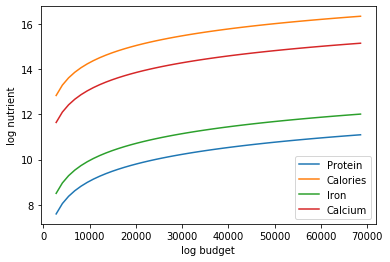

In [18]:
import numpy as np
import matplotlib.pyplot as plt

X = np.linspace(medianx/5,medianx*5,50).tolist()

UseNutrients = ['Protein','Calories','Iron','Calcium']

# Use reference prices
logN={}
for myx in X:
    logN[myx] = np.log(nutrient_demand(myx)[UseNutrients])
    
logN = pd.concat(logN,axis=1).T

plt.plot(X,logN)
plt.legend(UseNutrients)
plt.xlabel('log budget')
plt.ylabel('log nutrient')

Now how does nutrition vary with prices at median income?



Text(0, 0.5, 'log Nutrient')

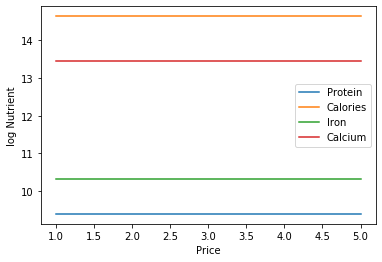

In [19]:
# Choose some good from your dataset
USE_GOOD = 'Milk'

P = np.linspace(1,5,20).tolist()

plt.plot(P,pd.concat({p0:np.log(nutrient_demand(medianx,pscale={USE_GOOD:p0})[UseNutrients]) for p0 in P},axis=1).T)
plt.legend(UseNutrients)
plt.xlabel('Price')
plt.ylabel('log Nutrient')